In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:

c=1.0 # velocidad de la onda
ly=1.0 # amplitud de la onda
lx=1.0
m=2   # modo normal y
n=2   # modo normal x
A=1
lr = 1e-3
layers = 10 # mejoro bastante al aumentar el numero de capas, no asi las epocs
neuronas = 128
epocs = 5_000 

In [4]:
# Modelo ecuacion de onda u(x,t)

class FunAct(nn.Module):
    def forward(self,x):
        return torch.tanh(x)


class MLP(nn.Module):
    def __init__(self, in_dim=3, out_dim=1, width=neuronas, depth=layers):
        super().__init__()
        capas = [nn.Linear(in_dim, width), FunAct()]
        for _ in range(depth - 1):
            capas += [nn.Linear(width, width), FunAct()]
        capas +=[nn.Linear(width, out_dim)]
        self.net=nn.Sequential(*capas)    

    def forward(self, x,y,t):
        XYT = torch.cat([x,y, t], dim=1)
        return self.net(XYT)
        

In [5]:
u = MLP().to(device)

In [6]:
def D(y, x):
    return torch.autograd.grad(y,x, torch.ones_like(y), retain_graph = True, create_graph= True)[0]
def psi(u,x,y,t):
    
    u_y = D(u,y)
    u_yy = D(u_y,y)

    u_x = D(u,x)
    u_xx = D(u_x,x)

    u_t = D(u,t)
    u_tt = D(u_t,t)

    return u_tt - c*c*u_xx - c*c*u_yy

def u_forward(t):
    return u(t)

In [7]:
### muestreo

N_poblado   = 5000
N_condicion = 200


In [8]:
optimizador = torch.optim.Adam(u.parameters(), lr)

In [9]:
loss_valores = []

for step in range(epocs):

    optimizador.zero_grad()


    t_poblado   = torch.rand((N_poblado, 1), device=device, requires_grad=True)
    x_poblado   = torch.rand((N_poblado, 1), device=device, requires_grad=True)
    y_poblado   = torch.rand((N_poblado, 1), device=device, requires_grad=True)

    t_condicion = torch.rand((N_condicion,1), device=device, requires_grad=True)
    x_condicion = torch.rand((N_condicion,1), device=device, requires_grad=True)
    y_condicion = torch.rand((N_condicion,1), device=device, requires_grad=True)

    ### condiciones de borde
    x0 = torch.zeros_like(x_condicion, device=device, requires_grad=True)
    xl = torch.ones_like(x_condicion,  device=device, requires_grad=True)*lx
    y0 = torch.zeros_like(y_condicion, device=device, requires_grad=True)
    yl = torch.ones_like(y_condicion,  device=device, requires_grad=True)*ly

    ### condiciones iniciales
    t0 = torch.zeros_like(t_condicion, device=device, requires_grad=True)

    residuo = psi(u(x_poblado,y_poblado,t_poblado),x_poblado,y_poblado,t_poblado)
    loss_residuo = (residuo**2).mean()

    u0yt = u(x0,y_condicion,t_condicion) 
    ulyt = u(xl,y_condicion,t_condicion) 

    ux0t = u(x_condicion,y0,t_condicion) 
    uxlt = u(x_condicion,yl,t_condicion) 

    loss_cb = (u0yt**2).mean() + (ulyt**2).mean() + (ux0t**2).mean() + (uxlt**2).mean()

    uxy0 = u(x_condicion,y_condicion,t0)
    uxy0_t = D(uxy0,t0)
    fxy = A*torch.sin(n*torch.pi*x_condicion/lx)*torch.sin(m*torch.pi*y_condicion/ly)
    gxy = torch.zeros_like(uxy0_t)

    loss_ci = ((uxy0-fxy)**2).mean() + ((uxy0_t-gxy)**2).mean()

    loss = loss_residuo + loss_cb + loss_ci

    loss_valores.append(loss.item())

    loss.backward()

    optimizador.step()

    if step % 200 == 0:
        print(f"step {step:4d} | loss {loss.item():.3e}")


C:\Users\danhm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


step    0 | loss 2.350e-01
step  200 | loss 2.459e-01
step  400 | loss 2.020e-01
step  600 | loss 1.859e-01
step  800 | loss 1.885e-01
step 1000 | loss 1.911e-01
step 1200 | loss 1.860e-01
step 1400 | loss 1.612e-01
step 1600 | loss 1.573e-01
step 1800 | loss 1.356e-01
step 2000 | loss 1.359e-01
step 2200 | loss 1.294e-01
step 2400 | loss 1.347e-01
step 2600 | loss 1.109e-01
step 2800 | loss 1.284e-01
step 3000 | loss 1.131e-01
step 3200 | loss 1.158e-01
step 3400 | loss 1.058e-01
step 3600 | loss 1.066e-01
step 3800 | loss 1.072e-01
step 4000 | loss 1.004e-01
step 4200 | loss 9.971e-02
step 4400 | loss 9.213e-02
step 4600 | loss 1.097e-01
step 4800 | loss 9.190e-02


Text(0, 0.5, 'Log Loss')

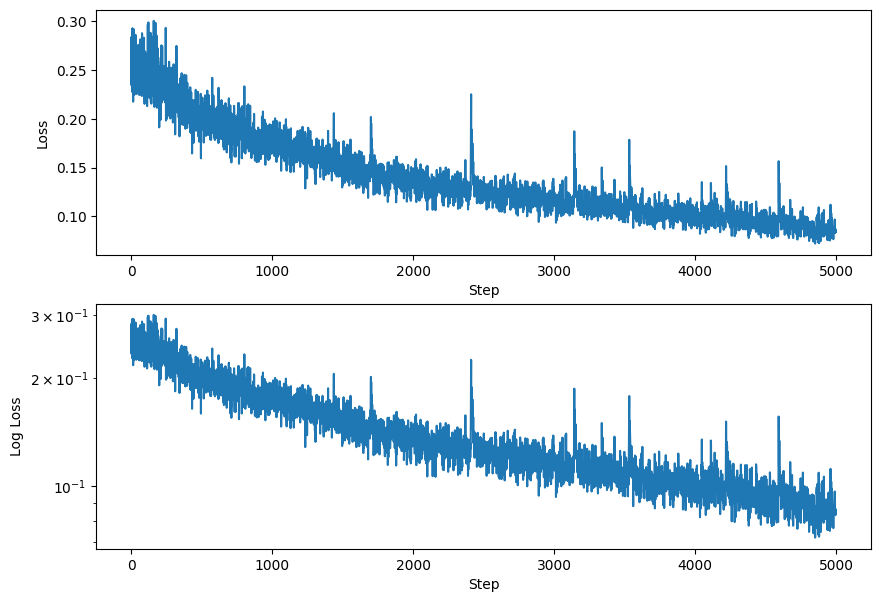

In [10]:
plt.figure(figsize=(10,7))

plt.subplot(2,1,1)
plt.plot(loss_valores)
plt.xlabel("Step"); plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(loss_valores)
plt.yscale('log')  # si baja exponencialmente
plt.xlabel("Step"); plt.ylabel("Log Loss")

In [11]:
def u_exacta(x,y,t):
    w = c*np.pi*np.sqrt((n/lx)**2 + (m/ly)**2)
    return A*np.cos(w*t)*np.sin(n*np.pi*x/lx)*np.sin(m*np.pi*y/ly)

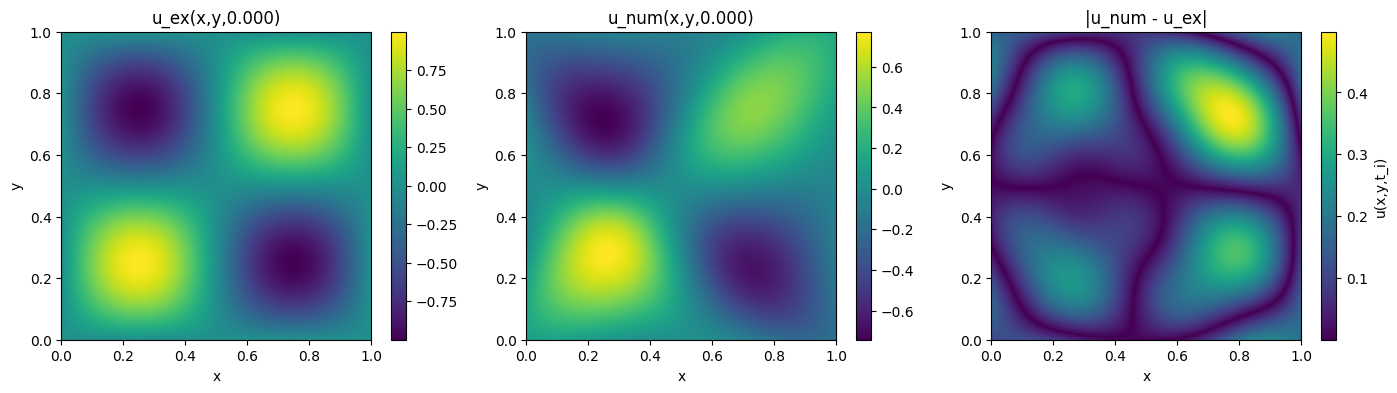

MSE @ t=0.000: 3.110e-02 | Error relativo L2: 3.536e-01


In [12]:
t_i = 0.0
with torch.no_grad():
    Nx, Ny = 400, 400
    x = torch.linspace(0.0, float(lx), Nx, device=device)
    y = torch.linspace(0.0, float(ly), Ny, device=device)

    # Malla 2D de tamaño (Ny, Nx)
    Yg, Xg = torch.meshgrid(y, x, indexing='ij')   # Yg: (Ny,Nx), Xg: (Ny,Nx)
    Tg = torch.full_like(Xg, float(t_i))

    # Evalúa PINN en toda la malla y reordena a 2D
    u_num = u(Xg.reshape(-1,1), Yg.reshape(-1,1), Tg.reshape(-1,1)) \
              .reshape(Ny, Nx) \
              .detach().cpu().numpy()

    # Exacta en la misma malla (ojo: antes estabas usando xg también para y)
    x_np = Xg.detach().cpu().numpy().ravel()
    y_np = Yg.detach().cpu().numpy().ravel()
    t_np = np.full_like(x_np, float(t_i), dtype=float)
    u_ex  = np.ravel(u_exacta(x_np, y_np, t_np)).reshape(Ny, Nx)

# Métricas (comparando como vectores)
mse = np.mean((u_num.ravel() - u_ex.ravel())**2)
rel_L2 = np.linalg.norm(u_num.ravel() - u_ex.ravel()) / max(1e-12, np.linalg.norm(u_ex.ravel()))

# Heatmap simple
plt.figure(figsize=(17,4))

plt.subplot(1,3,1)
plt.imshow(
    u_ex,
    extent=[x.min().item(), x.max().item(), y.min().item(), y.max().item()],
    origin='lower',
    aspect='auto'
)
plt.colorbar()
plt.xlabel('x'); plt.ylabel('y')
plt.title(f'u_ex(x,y,{float(t_i):.3f})')

plt.subplot(1,3,2)
plt.imshow(
    u_num,
    extent=[x.min().item(), x.max().item(), y.min().item(), y.max().item()],
    origin='lower',
    aspect='auto'
)
plt.colorbar()
plt.xlabel('x'); plt.ylabel('y')
plt.title(f'u_num(x,y,{float(t_i):.3f})')

plt.subplot(1,3,3)
plt.imshow(
    abs(u_num-u_ex),
    extent=[x.min().item(), x.max().item(), y.min().item(), y.max().item()],
    origin='lower',
    aspect='auto'
)
plt.colorbar(label='u(x,y,t_i)',)
plt.xlabel('x'); plt.ylabel('y')
plt.title(f'|u_num - u_ex|')

plt.show()

print(f"MSE @ t={float(t_i):.3f}: {mse:.3e} | Error relativo L2: {rel_L2:.3e}")
